In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns

In [2]:
movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_games_with_franchises.csv", index_col = 0)

C:\Users\35387\AppData\Local\Temp\ipykernel_92380\1545051576.py:1: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)


Naming convention to standardise the column names

In [3]:
games_df = games_df.rename(columns = {"titleType": "type", "rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

In [4]:
games_df.genres = games_df.genres.apply(lambda x: x.strip("[]").split(","))
games_df.genres = games_df.genres.apply(lambda x: [i.strip(" '") for i in x])
games_df.genres = games_df.genres.apply(lambda x: ', '.join(x))

In [5]:
movies_df["type"] = "movie"
games_df["type"] = "game"

In [6]:
complete_df = pd.concat([movies_df, games_df])

- Normalize movies and games 
- Calculate z-scores
- Add the following headings\
    &emsp;"Time until next movie"\
    &emsp;"Difference in rating"
    
    &emsp;"Number in Franchise"

Get number of movies/games in franchise

In [7]:
complete_df['franchise_count'] = complete_df['franchise_id'].map(complete_df['franchise_id'].value_counts())

Get total number of franchises:

In [8]:
complete_df[complete_df["type"] == "movie"].franchise_id.nunique()

1169

In [9]:
complete_df[complete_df["type"] == "games"].franchise_id.nunique()

0

Remove any movies or games where the total franchise count after matching the series is less than 3

In [ ]:
complete_df[["franchise_id", "franchise_name", "franchise_count"]] = complete_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1)

Get total number of franchises with more than 3:

In [ ]:
complete_df[complete_df["type"] == "movie"].franchise_id.nunique()

In [ ]:
complete_df[complete_df["type"] == "game"].franchise_id.nunique()

Remove non-numerical years from data and convert to int

In [ ]:
complete_df = complete_df[~(complete_df["year"] == "\\N")]
complete_df["year"] = complete_df["year"].apply(lambda x: int(x))

In [ ]:
complete_df

## Splitting the data
At this stage we are going to create 2 separate dataframes. The first will group all the franchises by year, and each year for each franchise will be a single entry. The second will keep all the individual entries for each year for each franchise. 

### Single Year Per Franchise

Create a copy

In [ ]:
merged_years_df = complete_df.copy(deep=True)

Convert genres to list

In [ ]:
merged_years_df["genres"] = merged_years_df.genres.apply(lambda x : x.split(','))

Get total for each year, for each franchise

In [ ]:
merged_years_df['content_per_year'] = merged_years_df.groupby(["franchise_id", "year"])["year"].transform('count')

Create average votes and ratings for each franchise

In [ ]:
grouped_movies = merged_years_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_years_df = pd.merge(merged_years_df, grouped_movies, on=["franchise_id", "year"], how="left", suffixes=(None, '_average'))

In [ ]:
# group by name and release year, aggregate the franchise_id lists
merged_years_df = merged_years_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    "type": "first",
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "is_adult": "first",
    "runtime" : "first",
    "genres": lambda x: list(set([i for l in x for i in l])),
    "votes_average": "first", 
    "rating_average": "first", 
    "franchise_count" : "first",
    "content_per_year": "first", 
    }))

Create columns that have the difference in year between the previous entries in the franchise, the difference in average vote count and avaerage rating

In [ ]:
merged_years_df.sample()

In [ ]:
merged_years_df = merged_years_df.sort_values(["franchise_id", "year"])
merged_years_df['year_diff'] = merged_years_df.groupby(['franchise_id'])['year'].diff()
merged_years_df['vote_diff'] = merged_years_df.groupby(['franchise_id'])['votes_average'].diff()
merged_years_df['rating_diff'] = merged_years_df.groupby(['franchise_id'])['rating_average'].diff()
merged_years_df['num_of_releases_diff'] = merged_years_df.groupby(['franchise_id'])['content_per_year'].diff()

In [ ]:
merged_years_df

At this stage, the merged_year_df contains all the movies within a franchise, grouped by year of release for each franchise, with columns that show how the number of releases, rating and vote count changed from the previous release year, and the number of years between subsequent releases. We'll export this information as a csv

In [69]:
merged_years_df["year_diff"].describe()

count    9369.000000
mean        3.261714
std         4.967059
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        83.000000
Name: year_diff, dtype: float64

### Returning to our original dataframe

Create additional columns for the datasets containing average rating for the franchises

In [75]:
complete_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count
0,Coffin Joe,f1,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1,Coffin' Joe,f822,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,Coffin Joe,f1,tt0062943,the strange world of coffin joe,1968,0,80,Horror,6.3,653.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
3,Coffin Joe,f1,tt0062690,awakening of the beast,1970,0,93,"Drama,Horror",5.8,1208.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
4,Coffin Joe,f1,tt0071479,exorcismo negro,1974,0,100,Horror,6.0,274.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,NaN,NaN,tt9888864,Infernal,2007,0,NaN,['Action'],6.0,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN
16986,NaN,NaN,tt9892552,Spiral Splatter,2017,0,NaN,['Action'],2.0,10.0,game,NaN,85.5,NaN,NaN,NaN,NaN,NaN
16987,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0,NaN,['Sci-Fi'],6.2,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN
16988,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0,NaN,"['Animation', 'Adventure', 'Family', 'Action-A...",5.5,156.0,game,22035.0,100.0,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,56.0


## *Note*
Using value_counts we discover 25% of our movies for the franchises are released in the same year. So we have to either get an average per year (in this case, we are looking at fatique over years as opposed to number of movies)

In [93]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff
1218,World Rally Championship,3025-1579,game,tt11617312,WRC 7: FIA World Rally Championship,2017,0,None,"[['\\N', 'Driving/Racing']]",19.0,6.1,9.0,1.0,1.0,-16.0,0.0,0.0


# Normalize and z-scores

In [ ]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])


In [99]:
cols = ["tconst", "rating_average", "votes_average", "year"]

games_scores = merged_years_df[merged_years_df["type"] == "game"][cols]

movies_scores = merged_years_df[merged_years_df["type"] == "movie"][cols]

In [100]:
%matplotlib inline

sns.set_context("talk", font_scale=.9)   
sns.set_context('talk')

fig_width, fig_height = 4, 3

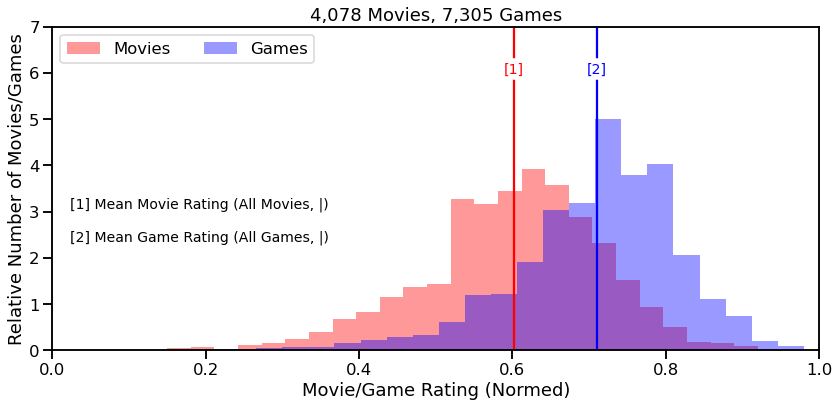

In [101]:
fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))

interval = 0.01
((movies_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_ylim(0, 7)
ax.set_xlim(0, 1)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

mean_movie_rating = (movies_scores['rating_average']/10).mean()
mean_game_rating = (games_scores['rating_average']/10).mean()

ax.axvline(mean_movie_rating, color="red")
ax.axvline(mean_game_rating, color="blue")

ax.text(mean_movie_rating, 6, '[1]', ha='center',color="red", backgroundcolor='w', fontsize=14)

ax.text(mean_game_rating, 6, '[2]', ha='center',color="blue", backgroundcolor='w', fontsize=14)


ax.text(
    0, 2,
    '''
    [1] Mean Movie Rating (All Movies, |)
    
    [2] Mean Game Rating (All Games, |)
    ''',
    fontsize=14
)

ax.set_xlabel('Movie/Game Rating (Normed)')
ax.set_ylabel('Relative Number of Movies/Games')

ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_scores), len(games_scores)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_1_normed_rating_distributions.png', format='png', dpi=300)

In [102]:
merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].agg(['mean', 'std'])

mean    6.015048
std     1.152526
Name: rating_average, dtype: float64

In [103]:
(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']-merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].mean())/complete_df[complete_df["type"] == "movie"]['rating'].std()

7305     0.649249
7306    -0.011040
7307     0.429152
7308     0.575883
7309     0.722614
           ...   
11378    0.282421
11379    0.722614
11380   -1.294935
11381   -0.597963
11382   -0.891425
Name: rating_average, Length: 4078, dtype: float64

In [104]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])

7305     0.767931
7306    -0.013058
7307     0.507601
7308     0.681154
7309     0.854707
           ...   
11378    0.334048
11379    0.854707
11380   -1.531648
11381   -0.707271
11382   -1.054377
Name: rating_average, Length: 4078, dtype: float64

In [105]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']).mean()

-2.512294769799153e-16

In [106]:
merged_years_df["z_rating"] = np.nan

In [107]:
merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])
merged_years_df.sort_values("z_rating")

C:\Users\35387\AppData\Local\Temp\ipykernel_63628\1374468612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])


,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating
0,Mario,3025-1,game,tt0315808,Baseball,1978,0,None,"[ 'Baseball', ['Sport', 'Family', 'Sports']]",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0176664,Donkey Kong,1981,0,None,"[['Action', 'Platformer']]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0,NaN
2,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,None,"[ 'Family'], 'Platformer', ['Action']",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0,NaN
3,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,None,"[ 'Platformer', ['Sport', 'Baseball', 'Pinba...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0,NaN
4,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,None,"[ 'Platformer', ['Puzzle', 'Action', 'Family...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,Renato Castellani's Italian neorealism trilogy,f993,movie,tt0040018,it's forever springtime,1950,0,92,"[Comedy, Drama]",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0,NaN
11379,Renato Castellani's Italian neorealism trilogy,f993,movie,tt0044572,two cents worth of hope,1952,0,110,"[Comedy, Romance]",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0,NaN
11380,It's Alive,f994,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Sci-Fi, Horror, Romance]",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,NaN
11381,It's Alive,f994,movie,tt0077756,it lives again,1978,0,91,"[Sci-Fi, Horror]",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0,NaN


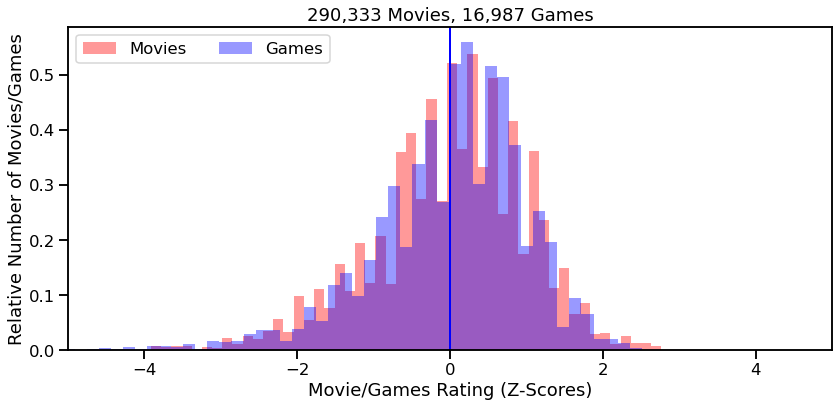

In [108]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])

merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])

fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))


((merged_years_df[merged_years_df["type"] == "movie"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="red", density=True, alpha=.4)
((merged_years_df[merged_years_df["type"] == "game"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_xlim(-5, 5)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

ax.axvline((merged_years_df[merged_years_df["type"] == "movie"]['z_rating']).mean(), lw=2, c="red")
ax.axvline((merged_years_df[merged_years_df["type"] == "game"]['z_rating']).mean(), lw=2, c="blue")


ax.set_xlabel('Movie/Games Rating (Z-Scores)')
ax.set_ylabel('Relative Number of Movies/Games')
ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_df), len(games_df)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_2_z_rating_distributions.png', format='png', dpi=300)

In [110]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'votes_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'votes_average'])

In [89]:
complete_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count,z_rating
237353,NaN,NaN,tt3604156,aliens: zone of silence,2017,0,79,"Horror,Mystery,Sci-Fi",3.5,602.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.963024


In [111]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes
2713,Trauma Center,3025-260,game,tt2126310,Trauma Team,2010,0,None,"[['Drama', 'Simulation']]",23.0,7.7,5.0,1.0,2.0,12.0,0.1,0.0,0.556838,-0.249406


In [112]:
merged_years_df.to_csv("franchises_combined_by_year.csv")

## Additional Unused Code

In [87]:
def sample_func(sub_df):
    
    movies_in_order = sub_df.sort_values('year')['tconst']
    return pd.Series({movie: k+1 for k, movie in enumerate(movies_in_order)})

In [88]:
sample_df = movies_df.sample(10000)
grouped_df = sample_df.groupby('franchise_id').apply(sample_func)

In [ ]:
franchise_df = grouped_df[grouped_df['franchise_id'] == 'f1334']

In [ ]:
sample_func(franchise_df)

In [ ]:
l = ['a','b','c']
for k,i in enumerate(l):
    print(k,i)
    print(i,  '-->',  k+1)

In [ ]:
franchise_df.sort_values('startYear')['startYear']

In [ ]:
franchise_df.set_index('tconst').sort_values('startYear')['startYear'].map(int).diff()